In [38]:
# -*- coding: utf-8 -*-
# -*- author : Lokman Mheni - Fabio Palmisano -*-
# -*- date : 2024-04-20 -*-
# -*- Last revision: 2024-06-10 *-
# -*- python version : 3.11.9 -*-
# -*- Description: Logistic Regression with new graph-*-

# <center> EE - 452: Network Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Bookreads recommenders </center>
---

In [39]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from itertools import combinations
from collections import defaultdict
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
seed = 42


books = pd.read_csv( 'data/books.csv' )
ratings = pd.read_csv('data/ratings.csv')
tr = pd.read_csv( 'data/to_read.csv' )

## Preprocessing of Ratings 

<Axes: >

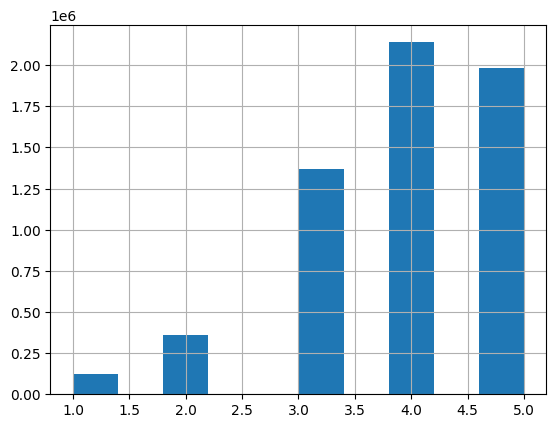

In [40]:
ratings['rating'].hist()

<Axes: >

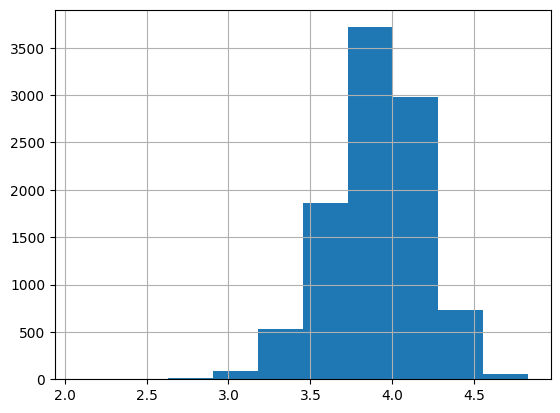

In [41]:
##  mean ratings per book 
mean_ratings = ratings.groupby('book_id')['rating'].mean()
mean_ratings.hist()

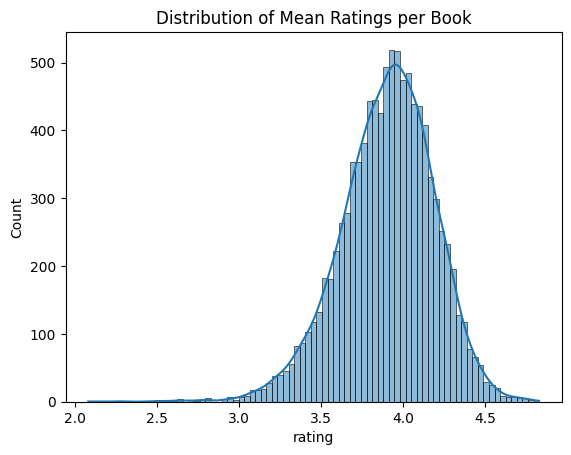

In [42]:
sns.histplot(mean_ratings, kde=True)
plt.title('Distribution of Mean Ratings per Book')
plt.show()

In [43]:
mean_ratings

book_id
1        4.279707
2        4.351350
3        3.214341
4        4.329369
5        3.772224
           ...   
9996     4.014184
9997     4.451613
9998     4.323529
9999     3.707692
10000    4.009009
Name: rating, Length: 10000, dtype: float64

<Axes: >

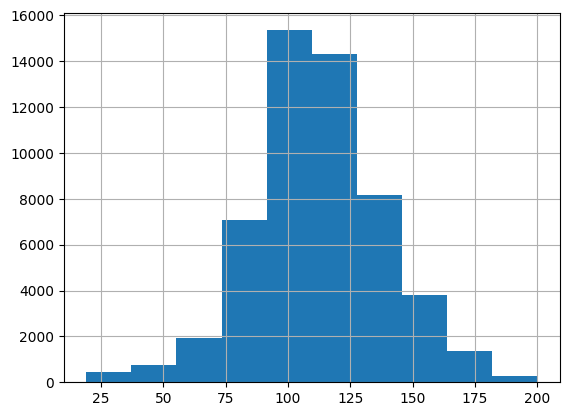

In [44]:
# Distribution of the number of ratings per user
user_ratings = ratings.groupby('user_id')['rating'].count()
user_ratings.hist()

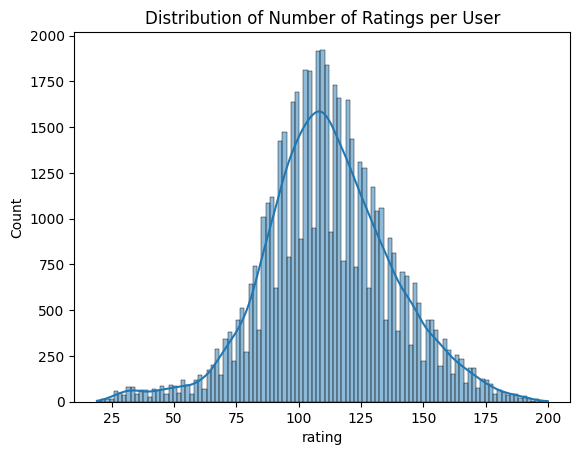

In [45]:

sns.histplot(user_ratings, kde=True)
plt.title('Distribution of Number of Ratings per User')
plt.show()

<Axes: >

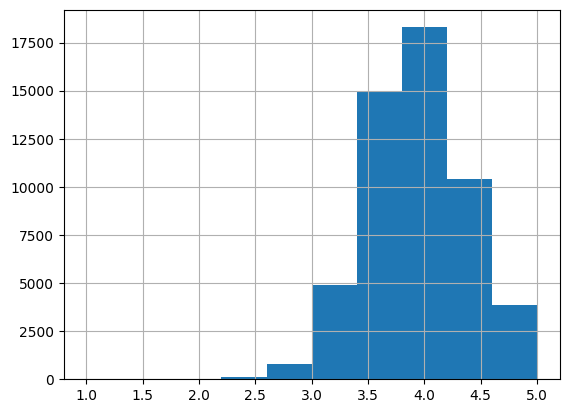

In [46]:
# mean ratings distribution per user
mean_user_ratings = ratings.groupby('user_id')['rating'].mean()
mean_user_ratings.hist()


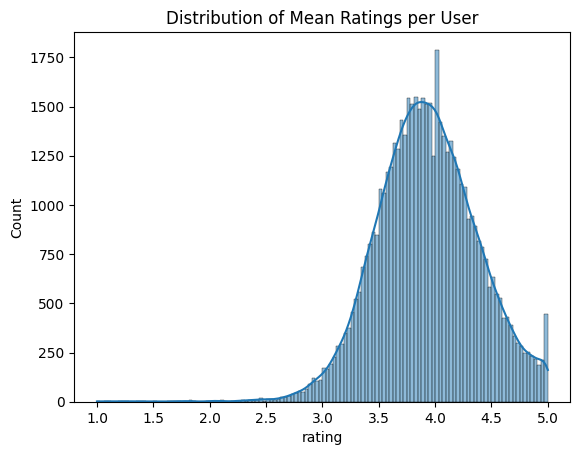

In [47]:
sns.histplot(mean_user_ratings, kde=True)
plt.title('Distribution of Mean Ratings per User')
plt.show()

In [48]:
user_ratings

user_id
1        117
2         65
3         91
4        134
5        100
        ... 
53420    110
53421    110
53422    130
53423     77
53424    133
Name: rating, Length: 53424, dtype: int64

In [49]:
seventyfive_percentile = user_ratings.quantile(0.60)
twentyfive_percentile = user_ratings.quantile(0.40)

In [50]:
seventyfive_percentile, twentyfive_percentile

(117.0, 105.0)

In [51]:
# We keep only the user that have rated between 25 and 75 percentile (between 96 and 128 books)
user_ratings = user_ratings[(user_ratings >= twentyfive_percentile) & (user_ratings <= seventyfive_percentile)]

In [52]:
user_ratings

user_id
1        117
12       113
14       108
18       109
50       106
        ... 
53398    110
53412    107
53414    116
53420    110
53421    110
Name: rating, Length: 11838, dtype: int64

In [53]:
mean_user_ratings

user_id
1        3.589744
2        4.415385
3        1.736264
4        3.768657
5        4.040000
           ...   
53420    3.345455
53421    4.609091
53422    4.215385
53423    4.454545
53424    4.406015
Name: rating, Length: 53424, dtype: float64

In [54]:
# Finally we keep only the user that have rated between 
# 40th percentile and 60th percentile (due to number of nodes and computational cost)
twentyfive_percentile_mean = mean_user_ratings.quantile(0.4)
seventyfive_percentile_mean = mean_user_ratings.quantile(0.6)

twentyfive_percentile_mean, seventyfive_percentile_mean

(3.810810810810811, 4.03030303030303)

In [55]:
# We keep only the user that have rated between 25 and 75 percentile (between 3.6339 and 4.22321)
mean_user_ratings = mean_user_ratings[(mean_user_ratings >= twentyfive_percentile_mean) & (mean_user_ratings <= seventyfive_percentile_mean)]
mean_user_ratings


user_id
7        3.819355
12       3.867257
17       4.016393
25       4.016667
26       3.990291
           ...   
53394    3.972973
53395    3.914894
53405    3.891892
53408    3.838710
53413    3.908333
Name: rating, Length: 10693, dtype: float64

In [56]:
# We filter and keep only the users that are in both the user_ratings and mean_user_ratings
users = set(user_ratings.index) & set(mean_user_ratings.index)

In [57]:
len(users)

2578

In [58]:
# Oke and now we can keep only the ratings that are in the intersection of the users and books
ratings = ratings[ratings['user_id'].isin(users)]

In [59]:
ratings

,user_id,book_id,rating
822,72,4,5
823,72,55,3
824,72,8,2
825,72,550,5
827,72,1714,5
...,...,...,...
5976135,18147,6753,4
5976136,18147,7892,2
5976322,1670,3371,5
5976323,41342,3175,4


In [60]:
ratings.book_id.nunique()

9823

---
## Graph Creation (Book to Book based on ratings)


In [61]:
from tqdm import tqdm

book_to_book = nx.Graph()

# Get a list of unique users
users = ratings['user_id'].unique()

for user in tqdm(users):
    books = ratings[ratings['user_id'] == user]['book_id']
    for book1, book2 in combinations(books, 2):
        if book_to_book.has_edge(book1, book2):
            book_to_book[book1][book2]['weight'] += 1
        else:
            book_to_book.add_edge(book1, book2, weight=1)

100%|██████████| 2578/2578 [00:18<00:00, 139.25it/s]


In [62]:
print(len(book_to_book.nodes()))
print(len(book_to_book.edges()))

9823
6235818


In [63]:
number_to_read =  tr['book_id'].value_counts()
number_to_read = number_to_read.apply(lambda x: 1 if x >= 50 else 0)
number_to_read

book_id
47      1
143     1
113     1
13      1
11      1
       ..
6297    0
7951    0
4434    0
9124    0
8946    0
Name: count, Length: 9986, dtype: int64

In [64]:
number_to_read.value_counts()

count
0    5641
1    4345
Name: count, dtype: int64

In [65]:
nx.set_node_attributes(book_to_book, number_to_read.to_dict(), 'to_read')

In [66]:
book_to_book.nodes[1]

{'to_read': 1}

In [67]:
#check in G_user_books_sample the proportion of nodes set to label 1 (to read) and which are set to 0 (not to read)
to_read = 0
not_to_read = 0
for node in book_to_book.nodes(data=True):
    if node[1].get('to_read', 0) == 1:
        to_read += 1
    else:
        not_to_read += 1
print(to_read, not_to_read)

4334 5489


In [68]:
graph_labels = nx.get_node_attributes(book_to_book, 'to_read')
graph_labels

{4: 1,
 55: 1,
 8: 1,
 550: 1,
 1714: 1,
 118: 1,
 848: 1,
 867: 1,
 10: 1,
 2136: 1,
 230: 1,
 171: 1,
 471: 1,
 64: 1,
 1159: 1,
 2679: 1,
 1060: 1,
 8457: 0,
 408: 1,
 261: 1,
 1313: 1,
 70: 1,
 26: 1,
 89: 1,
 7: 1,
 92: 1,
 211: 1,
 127: 1,
 76: 1,
 344: 1,
 534: 1,
 101: 1,
 4363: 1,
 2128: 1,
 67: 1,
 544: 1,
 681: 1,
 1644: 1,
 1386: 1,
 3293: 1,
 3579: 1,
 4322: 0,
 407: 1,
 3456: 1,
 33: 1,
 37: 1,
 136: 1,
 66: 1,
 123: 1,
 84: 1,
 626: 0,
 620: 1,
 29: 1,
 75: 1,
 148: 1,
 2671: 0,
 42: 1,
 453: 1,
 1457: 0,
 228: 1,
 212: 1,
 496: 1,
 222: 1,
 919: 1,
 2015: 0,
 343: 1,
 15: 1,
 133: 1,
 225: 1,
 58: 1,
 179: 1,
 32: 1,
 119: 1,
 150: 1,
 468: 1,
 22: 1,
 180: 1,
 102: 1,
 59: 1,
 461: 1,
 198: 1,
 271: 1,
 740: 1,
 795: 1,
 38: 1,
 108: 1,
 955: 0,
 1063: 1,
 1436: 0,
 952: 1,
 308: 1,
 411: 1,
 509: 1,
 8384: 0,
 126: 1,
 100: 1,
 398: 1,
 372: 1,
 8627: 0,
 8218: 0,
 98: 1,
 140: 1,
 6: 1,
 137: 1,
 99: 1,
 1: 1,
 1076: 1,
 1396: 1,
 5328: 0,
 24: 1,
 495: 1,
 45: 1,
 5

---
## Model with features

In [55]:
node_features = pd.DataFrame(index=book_to_book.nodes())
print("Node features1: ", node_features)
# Calculate the degree 
node_features['degree'] = pd.Series(dict(book_to_book.degree()))
print("Node features2: ", node_features)
# Calculate the degree centrality 
node_features['degree_centrality'] = pd.Series(nx.degree_centrality(book_to_book))
print("Node features3: ", node_features)
# Calculate the eigenvector centrality 
node_features['eigenvector_centrality'] = pd.Series(nx.eigenvector_centrality(book_to_book))
print("Node features4: ", node_features)
# Calculate the PageRank of each node
node_features['pagerank'] = pd.Series(nx.pagerank(book_to_book))
print("Node features8: ", node_features)
# Calculate the average neighbor degree 
node_features['average_neighbor_degree'] = pd.Series(nx.average_neighbor_degree(book_to_book))
print("Node features9: ", node_features)
# Merge the node features with the graph labels
node_features = node_features.merge(pd.Series(graph_labels, name ='graph_labels'), left_index=True, right_index=True)
print("Node features10: ", node_features)

X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)
print("Node features11: ", node_features)
# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)


f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

Node features1:  Empty DataFrame
Columns: []
Index: [4, 55, 8, 550, 1714, 118, 848, 867, 10, 2136, 230, 171, 471, 64, 1159, 2679, 1060, 8457, 408, 261, 1313, 70, 26, 89, 7, 92, 211, 127, 76, 344, 534, 101, 4363, 2128, 67, 544, 681, 1644, 1386, 3293, 3579, 4322, 407, 3456, 33, 37, 136, 66, 123, 84, 626, 620, 29, 75, 148, 2671, 42, 453, 1457, 228, 212, 496, 222, 919, 2015, 343, 15, 133, 225, 58, 179, 32, 119, 150, 468, 22, 180, 102, 59, 461, 198, 271, 740, 795, 38, 108, 955, 1063, 1436, 952, 308, 411, 509, 8384, 126, 100, 398, 372, 8627, 8218, ...]

[9823 rows x 0 columns]
Node features2:        degree
4       8916
55      7274
8       8307
550     3664
1714    2318
...      ...
6075     104
9971     104
9548     104
9535     104
9015     104

[9823 rows x 1 columns]
Node features3:        degree  degree_centrality
4       8916           0.907758
55      7274           0.740582
8       8307           0.845754
550     3664           0.373040
1714    2318           0.236001
...      ...   

,Real,Predicted
2290,1,1
2683,0,1
7710,0,0
19,1,1
8557,0,0
...,...,...
5954,1,0
2437,1,1
9896,1,0
9200,0,0


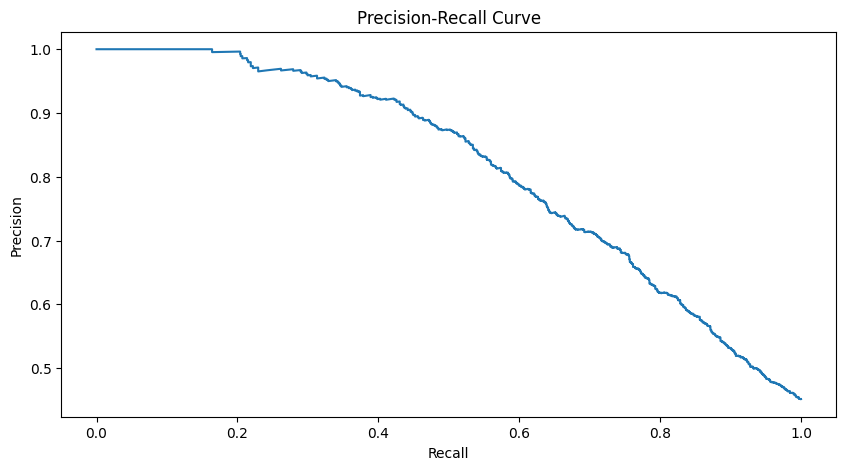

In [56]:
from sklearn.metrics import precision_recall_curve

# Get the probabilities of the positive class
y_scores = model.predict_proba(X_test)[:, 1]

# Get the precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Find the threshold that gives the best F1 score
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]

# Use this threshold to predict the classes
y_pred = (y_scores > best_threshold).astype(int)

# Print the precision-recall curve for the model 
plt.figure(figsize=(10, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

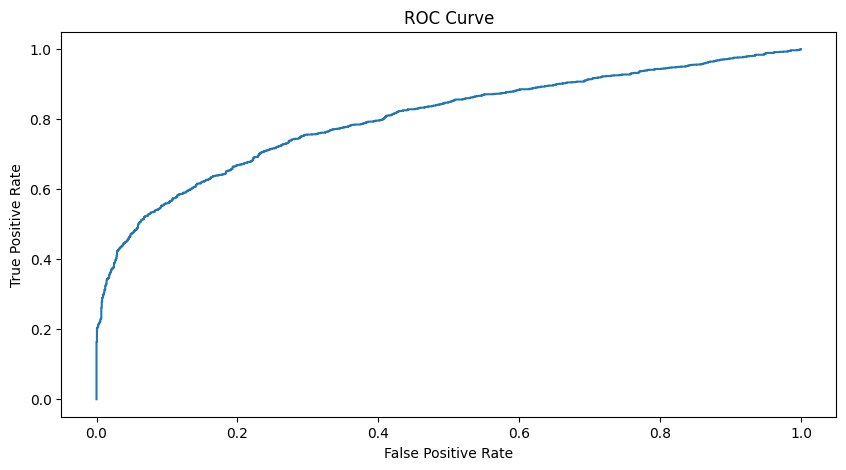

In [57]:
# Plot the ROC curve
from sklearn.metrics import roc_curve

# Get the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

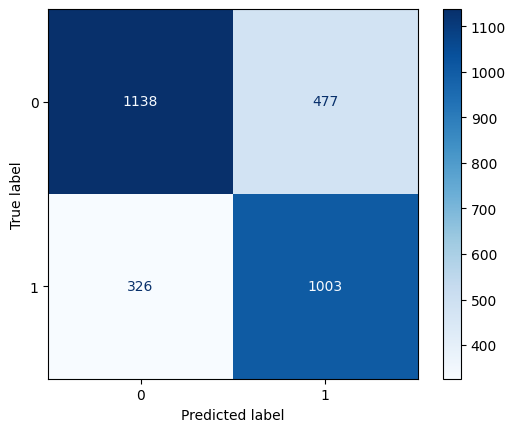

In [58]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()


In [86]:
seed = 42
node_features = pd.DataFrame(index=book_to_book.nodes())
print("Node features1: ", node_features)
# Calculate the degree of each node
node_features['degree'] = pd.Series(dict(book_to_book.degree()))
print("Node features2: ", node_features)
# Calculate the degree centrality of each node
node_features['degree_centrality'] = pd.Series(nx.degree_centrality(book_to_book))
print("Node features3: ", node_features)
# Calculate the closeness centrality of each node
node_features['closeness'] = pd.Series(nx.closeness_centrality(book_to_book))
print("Node features4: ", node_features)
# Calculate the betweenness centrality of each node
node_features['betweenness'] = pd.Series(nx.betweenness_centrality(book_to_book))
print("Node features5: ", node_features)
#Calculate the clustering coefficient of each node
node_features['clustering'] = pd.Series(nx.clustering(book_to_book))
print("Node features6: ", node_features)
# Calculate the eigenvector centrality of each node
node_features['eigenvector'] = pd.Series(nx.eigenvector_centrality(book_to_book))
print("Node features7: ", node_features)
# Calculate the pagerank of each node
node_features['pagerank'] = pd.Series(nx.pagerank(book_to_book))
print("Node features8: ", node_features)
# Calculate the average neighbor degree of each node
node_features['average_neighbor_degree'] = pd.Series(nx.average_neighbor_degree(book_to_book))
print("Node features9: ", node_features)
# Merge the node features with the graph labels
node_features = node_features.merge(pd.Series(graph_labels, name ='graph_labels'), left_index=True, right_index=True)
print("Node features10: ", node_features)
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)
print("Node features11: ", node_features)
# Train a simple model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

f1_score(y_test, y_pred)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

Node features1:  Empty DataFrame
Columns: []
Index: [4, 55, 8, 550, 1714, 118, 848, 867, 10, 2136, 230, 171, 471, 64, 1159, 2679, 1060, 8457, 408, 261, 1313, 70, 26, 89, 7, 92, 211, 127, 76, 344, 534, 101, 4363, 2128, 67, 544, 681, 1644, 1386, 3293, 3579, 4322, 407, 3456, 33, 37, 136, 66, 123, 84, 626, 620, 29, 75, 148, 2671, 42, 453, 1457, 228, 212, 496, 222, 919, 2015, 343, 15, 133, 225, 58, 179, 32, 119, 150, 468, 22, 180, 102, 59, 461, 198, 271, 740, 795, 38, 108, 955, 1063, 1436, 952, 308, 411, 509, 8384, 126, 100, 398, 372, 8627, 8218, ...]

[9823 rows x 0 columns]
Node features2:        degree
4       8916
55      7274
8       8307
550     3664
1714    2318
...      ...
6075     104
9971     104
9548     104
9535     104
9015     104

[9823 rows x 1 columns]
Node features3:        degree  degree_centrality
4       8916           0.907758
55      7274           0.740582
8       8307           0.845754
550     3664           0.373040
1714    2318           0.236001
...      ...   

,Real,Predicted
2290,1,1
2683,0,1
7710,0,0
19,1,1
8557,0,0
...,...,...
5954,1,0
2437,1,1
9896,1,0
9200,0,0


In [87]:
results = pd.DataFrame(columns=['features', 'accuracy', 'f1_score'])

for i in range(1, len(node_features.columns) - 1):
    for features in combinations(node_features.columns[:-1], i):
        print(features)
        X_train, X_test, y_train, y_test = train_test_split(node_features[list(features)], node_features['graph_labels'], test_size=0.3, random_state=seed)

        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results.loc[len(results)] = [features, accuracy, f1]
        print(accuracy, f1)

results.sort_values('f1_score', ascending=False).head(10)

# Print the best combinaison
best_combinaison = results.sort_values('f1_score', ascending=False).iloc[0]
print("Best combinaison of features:")
print(best_combinaison['features'])
print("Accuracy:", best_combinaison['accuracy'])
print("F1 Score:", best_combinaison['f1_score'])

('degree',)
0.7540760869565217 0.690068493150685
('degree_centrality',)
0.7493206521739131 0.6765994741454864
('closeness',)
0.7333559782608695 0.611578426521524
('betweenness',)
0.5485733695652174 0.0
('clustering',)
0.7221467391304348 0.6701612903225806
('eigenvector',)
0.5512907608695652 0.011967090501121916
('pagerank',)
0.5485733695652174 0.0
('average_neighbor_degree',)
0.5485733695652174 0.0
('degree', 'degree_centrality')
0.7540760869565217 0.690068493150685
('degree', 'closeness')
0.7540760869565217 0.690068493150685
('degree', 'betweenness')
0.7540760869565217 0.690068493150685
('degree', 'clustering')
0.7533967391304348 0.6918505942275043
('degree', 'eigenvector')
0.7540760869565217 0.690068493150685
('degree', 'pagerank')
0.7540760869565217 0.690068493150685
('degree', 'average_neighbor_degree')
0.7455842391304348 0.6832980972515855
('degree_centrality', 'closeness')
0.7496603260869565 0.6774617067833698
('degree_centrality', 'betweenness')
0.7493206521739131 0.676599474145

## Neural Network 

Epoch 1, Loss: 0.9936193619356599
Epoch 2, Loss: 0.7009168229823889
Epoch 3, Loss: 0.6118769608264746
Epoch 4, Loss: 0.6051869682101316
Epoch 5, Loss: 0.5865099588798922
Epoch 6, Loss: 0.5887470343431761
Epoch 7, Loss: 0.5937920837901359
Epoch 8, Loss: 0.5779743950034297
Epoch 9, Loss: 0.5745274035043495
Epoch 10, Loss: 0.5720060955299887


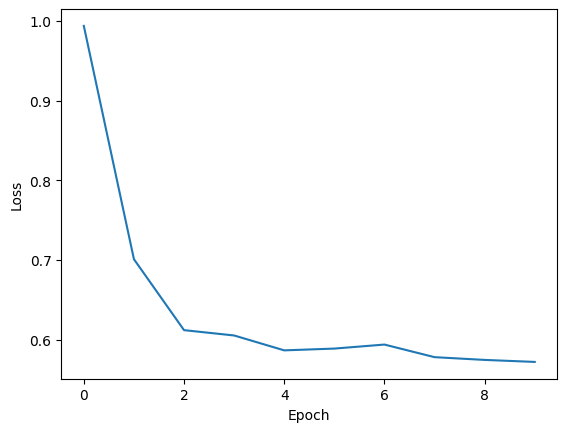

Accuracy: 74.69
F1 Score: 0.65


In [89]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset


X_train, X_test, y_train, y_test = train_test_split(node_features[list(best_combinaison['features'])], node_features['graph_labels'], test_size=0.3, random_state=seed)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

#model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

losses = []

for epoch in range(10):
    epoch_losses = []
    for inputs, targets in train_loader:

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f'Epoch {epoch+1}, Loss: {losses[-1]}')


plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#Results

with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print('Accuracy: %.2f' % (accuracy*100))

f1 = f1_score(y_test_tensor, predicted)
print('F1 Score: %.2f' % f1)

Epoch 1, Loss: 0.717364442417788
Epoch 2, Loss: 0.593412497154502
Epoch 3, Loss: 0.5500479156887809
Epoch 4, Loss: 0.5350732993247898
Epoch 5, Loss: 0.5381518598905829
Epoch 6, Loss: 0.5345046464440435
Epoch 7, Loss: 0.5339095853095831
Epoch 8, Loss: 0.5326990772125333
Epoch 9, Loss: 0.5339981985300086
Epoch 10, Loss: 0.5355843729751054
Epoch 11, Loss: 0.5334240749824879
Epoch 12, Loss: 0.5332387030817741
Epoch 13, Loss: 0.5362511778293654
Epoch 14, Loss: 0.5317506374314774
Epoch 15, Loss: 0.5307690343537996
Epoch 16, Loss: 0.5311255204816198
Epoch 17, Loss: 0.5307536082905392
Epoch 18, Loss: 0.5303641381651856
Epoch 19, Loss: 0.5298435841188874
Epoch 20, Loss: 0.5287236757403196
Epoch 21, Loss: 0.5298460212557815
Epoch 22, Loss: 0.5294408176180928
Epoch 23, Loss: 0.5290772027054499
Epoch 24, Loss: 0.5280035816306292
Epoch 25, Loss: 0.5285949971093687
Epoch 26, Loss: 0.5273315939792367
Epoch 27, Loss: 0.5288152440689331
Epoch 28, Loss: 0.5281495051675065
Epoch 29, Loss: 0.5271800171843

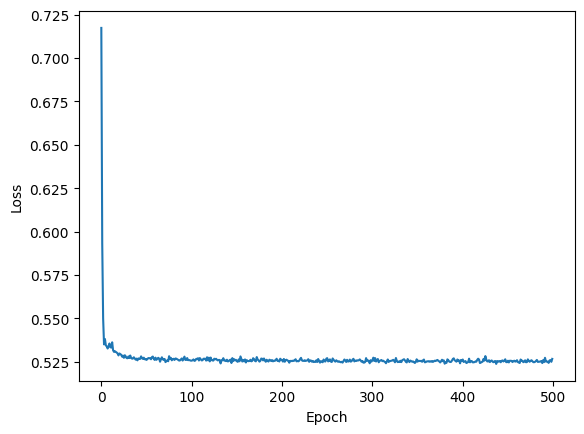

Accuracy: 75.41
F1 Score: 0.69


In [90]:
# Define a more complex model (add layers)
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)


criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


losses = []

# Train the model
for epoch in range(500):  # Increase the number of epochs
    epoch_losses = []
    for inputs, targets in train_loader:

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        loss.backward()
        optimizer.step()


        epoch_losses.append(loss.item())


    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f'Epoch {epoch+1}, Loss: {losses[-1]}')


plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print('Accuracy: %.2f' % (accuracy*100))

# Calculate and print the F1 score
f1 = f1_score(y_test_tensor, predicted)
print('F1 Score: %.2f' % f1)

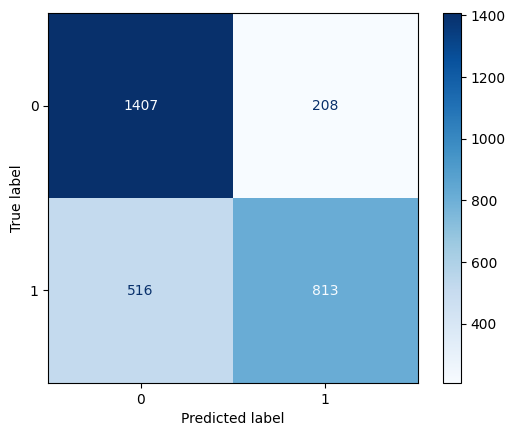

In [94]:
cm = confusion_matrix(y_test_tensor, predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()



In [96]:
# We store the data present in the node features dataframe 
node_features.to_csv('data/node_features.csv')

---
## Adding the features of the books

In [101]:
# Read the node features from the CSV file
node_features = pd.read_csv('data/node_features.csv', index_col=0)

In [102]:
books = pd.read_csv( 'data/books.csv' )


In [103]:
node_features

,degree,degree_centrality,closeness,betweenness,clustering,eigenvector,pagerank,average_neighbor_degree,graph_labels
4,8916,0.907758,0.915548,0.004831,0.148205,0.036999,0.002910,1357.947734,1
55,7274,0.740582,0.794018,0.002438,0.183617,0.033192,0.001425,1507.655348,1
8,8307,0.845754,0.866367,0.003663,0.161138,0.035819,0.002213,1414.736126,1
550,3664,0.373040,0.614643,0.000331,0.324653,0.021262,0.000322,1988.850437,1
1714,2318,0.236001,0.566894,0.000098,0.425887,0.015265,0.000151,2334.994392,1
...,...,...,...,...,...,...,...,...,...
6075,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0
9971,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0
9548,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0
9535,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0


In [104]:
book_ids = node_features.index
# Set the index of the books DataFrame to be the book_id
books.set_index('book_id', inplace=True)

# Filter the books DataFrame to only include books that are in node_features
filtered_books = books.loc[book_ids]

# Add the features to node_features
node_features['average_rating'] = filtered_books['average_rating']
node_features['ratings_count'] = filtered_books['ratings_count']
node_features['text_reviews_count'] = filtered_books['work_text_reviews_count']
node_features['publication_year'] = filtered_books['original_publication_year']

for i in range(1, 6):
    column_name = f'ratings_{i}'
    node_features[column_name] = filtered_books[column_name]

In [105]:
# Remove all the columns that have Nan values
node_features = node_features.dropna(axis=1)

In [106]:
# Check all the columns of the node_features dataframe if they have Nan values
node_features.isnull().sum()

degree                     0
degree_centrality          0
closeness                  0
betweenness                0
clustering                 0
eigenvector                0
pagerank                   0
average_neighbor_degree    0
graph_labels               0
average_rating             0
ratings_count              0
text_reviews_count         0
ratings_1                  0
ratings_2                  0
ratings_3                  0
ratings_4                  0
ratings_5                  0
dtype: int64

      degree  degree_centrality  closeness  betweenness  clustering  \
4       8916           0.907758   0.915548     0.004831    0.148205   
55      7274           0.740582   0.794018     0.002438    0.183617   
8       8307           0.845754   0.866367     0.003663    0.161138   
550     3664           0.373040   0.614643     0.000331    0.324653   
1714    2318           0.236001   0.566894     0.000098    0.425887   
...      ...                ...        ...          ...         ...   
6075     104           0.010588   0.426506     0.000000    1.000000   
9971     104           0.010588   0.426506     0.000000    1.000000   
9548     104           0.010588   0.426506     0.000000    1.000000   
9535     104           0.010588   0.426506     0.000000    1.000000   
9015     104           0.010588   0.502327     0.000000    1.000000   

      eigenvector  pagerank  average_neighbor_degree  graph_labels  \
4        0.036999  0.002910              1357.947734             1   
55     

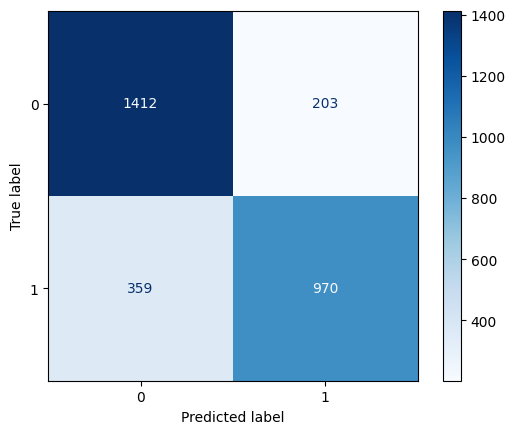

In [12]:
seed = 42
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
print(node_features)
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train model
model = LogisticRegression(max_iter = 10000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Results 
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()




In [80]:
# BE CAREFUL THIS CELL TAKES A LOT OF TIME TO RUN
from tqdm import tqdm


results = pd.DataFrame(columns=['features', 'accuracy', 'f1_score'])
columns_without_labels = [col for col in node_features.columns if col != 'graph_labels']

# Calculate total combinations
total_combinations = sum(1 for _ in combinations(columns_without_labels, i) for i in range(1, len(node_features.columns) - 1))

with tqdm(total=total_combinations, desc="Processing combinations") as pbar:
    # Iterate over all possible combinations of features
    for i in range(1, len(node_features.columns) - 1):
        for features in combinations(columns_without_labels, i):
            X_train, X_test, y_train, y_test = train_test_split(node_features[list(features)], node_features['graph_labels'], test_size=0.3, random_state=seed)

            # Train  model
            model = LogisticRegression(max_iter = 10000)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            results.loc[len(results)] = [features, accuracy, f1]


            pbar.update()

results.sort_values('f1_score', ascending=False).head(10)

# Print the best combination
best_combination = results.sort_values('f1_score', ascending=False).iloc[0]
print("Best combination of features:")
print(best_combination['features'])
print("Accuracy:", best_combination['accuracy'])
print("F1 Score:", best_combination['f1_score'])

Processing combinations: 65534it [1:19:09, 13.80it/s]                             


Best combination of features:
('degree', 'degree_centrality', 'betweenness', 'clustering', 'eigenvector', 'pagerank', 'average_rating', 'ratings_count', 'text_reviews_count', 'ratings_1', 'ratings_3', 'ratings_4', 'ratings_5')
Accuracy: 0.8206521739130435
F1 Score: 0.7872683319903304


# Try Some Neural Networks

In [75]:
# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(node_features[best_combination], node_features['graph_labels'], test_size=0.3, random_state=seed)

# Train model
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(y_pred)
accuracy_score(y_test, y_pred)

f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

[1 1 0 ... 0 0 0]
Accuracy:  0.8291440217391305
F1 Score:  0.800476001586672


,Real,Predicted
2290,1,1
2683,0,1
7710,0,0
19,1,1
8557,0,0
...,...,...
5954,1,1
2437,1,1
9896,1,0
9200,0,0


In [65]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples 
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Bootstraping yes or no ?
}

# Create the model
rf = RandomForestClassifier(random_state=seed)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search 
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

best_model = RandomForestClassifier(**best_params, random_state=seed)
best_model.fit(X_train, y_train)

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred_best))
print("F1 Score: ", f1_score(y_test, y_pred_best))

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best parameters:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy:  0.8301630434782609
F1 Score:  0.7999999999999999


In [76]:
# Train the model with the best parameters of random forest 
# and standardize the features with the best combination of features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
best_model = RandomForestClassifier(**best_params, random_state=seed)
best_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_best = best_model.predict(X_test_scaled)

accuracy_score(y_test, y_pred_best)


f1_score(y_test, y_pred_best)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred_best))
print("F1 Score: ", f1_score(y_test, y_pred_best))



Accuracy:  0.8325407608695652
F1 Score:  0.802721088435374


---------------------------------------------------------------------------

## GNN 

Epoch 1, Loss: 19.364003405460092
Epoch 2, Loss: 19.36809576832971
Epoch 3, Loss: 19.371988745622858
Epoch 4, Loss: 19.368095772765404
Epoch 5, Loss: 19.37198873675147
Epoch 6, Loss: 19.3680957772011
Epoch 7, Loss: 19.375881705173228
Epoch 8, Loss: 19.36809576832971
Epoch 9, Loss: 19.36809576832971
Epoch 10, Loss: 19.371988745622858
Epoch 11, Loss: 19.368095772765404
Epoch 12, Loss: 19.37198873675147
Epoch 13, Loss: 19.36809576832971
Epoch 14, Loss: 19.3680957772011
Epoch 15, Loss: 19.37588171848031
Epoch 16, Loss: 19.3680957772011
Epoch 17, Loss: 19.375881705173228
Epoch 18, Loss: 19.37198873675147
Epoch 19, Loss: 19.368095781636793
Epoch 20, Loss: 19.36809576832971
Epoch 21, Loss: 19.375881709608922
Epoch 22, Loss: 19.371988745622858
Epoch 23, Loss: 19.368095772765404
Epoch 24, Loss: 19.37198873675147
Epoch 25, Loss: 19.368095772765404
Epoch 26, Loss: 19.36809576832971
Epoch 27, Loss: 19.375881714044617
Epoch 28, Loss: 19.368095772765404
Epoch 29, Loss: 19.371988741187163
Epoch 30, L

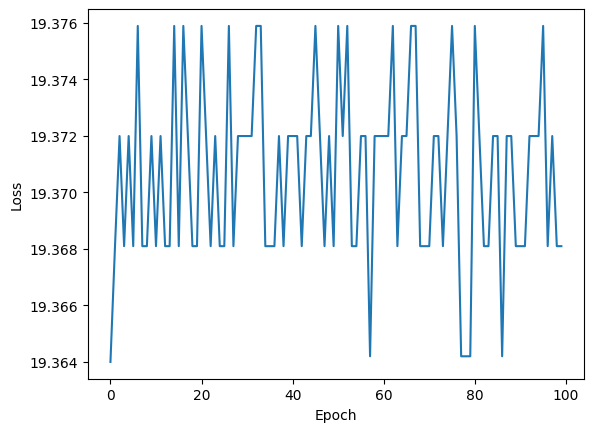

Accuracy: 45.14
F1 Score: 0.62


In [58]:
# Try With GNN 
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

losses = []

for epoch in range(100):
    epoch_losses = []
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f'Epoch {epoch+1}, Loss: {losses[-1]}')

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print('Accuracy: %.2f' % (accuracy*100))

# Calculate and print the F1 score
f1 = f1_score(y_test_tensor, predicted)
print('F1 Score: %.2f' % f1)

Epoch 1, Train Loss: 56.25968991656636, Val Loss: 57.56914138793945
Epoch 2, Train Loss: 56.32267441860465, Val Loss: 57.56914138793945
Epoch 3, Train Loss: 56.19670542339946, Val Loss: 57.56914138793945
Epoch 4, Train Loss: 56.19670542339946, Val Loss: 57.56914138793945
Epoch 5, Train Loss: 56.25968991656636, Val Loss: 57.56914138793945
Epoch 6, Train Loss: 56.25968991656636, Val Loss: 57.56914138793945
Epoch 7, Train Loss: 56.25968991656636, Val Loss: 57.56914138793945
Epoch 8, Train Loss: 56.19670542339946, Val Loss: 57.56914138793945
Epoch 9, Train Loss: 56.32267441860465, Val Loss: 57.56914138793945
Epoch 10, Train Loss: 56.25968991656636, Val Loss: 57.56914138793945
Epoch 11, Train Loss: 56.32267441860465, Val Loss: 57.56914138793945
Epoch 12, Train Loss: 56.25968991656636, Val Loss: 57.56914138793945
Epoch 13, Train Loss: 56.32267441860465, Val Loss: 57.56914138793945
Epoch 14, Train Loss: 56.19670542339946, Val Loss: 57.56914138793945
Epoch 15, Train Loss: 56.25968991656636, Va

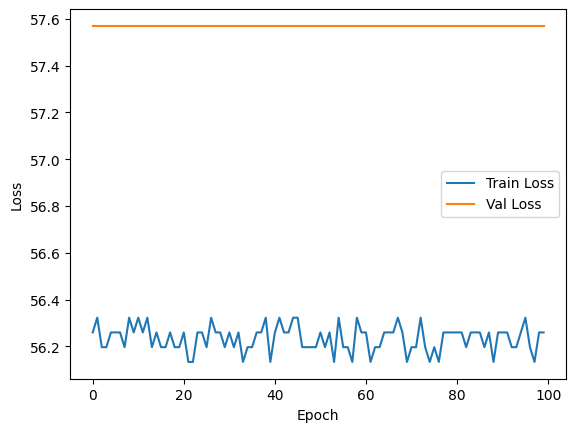

Accuracy: 45.14
F1 Score: 0.62


In [21]:
# Try to fix the model because it's strange results 
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

train_losses = []
val_losses = []

for epoch in range(100):
    epoch_train_losses = []
    for inputs, targets in train_loader:

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

    train_losses.append(sum(epoch_train_losses) / len(epoch_train_losses))

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
    val_losses.append(val_loss.item())
    model.train()

 
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')


plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print('Accuracy: %.2f' % (accuracy*100))

# Calculate and print the F1 score
f1 = f1_score(y_test_tensor, predicted)
print('F1 Score: %.2f' % f1)

The results are really bad.. so we will check why in GNN.ipynb

## Store the graphs and features in CSV to reuse it 

In [93]:
# Store all the features in a CSV file
node_features.to_csv('data/node_features_extended.csv')

In [107]:
node_features

,degree,degree_centrality,closeness,betweenness,clustering,eigenvector,pagerank,average_neighbor_degree,graph_labels,average_rating,ratings_count,text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
4,8916,0.907758,0.915548,0.004831,0.148205,0.036999,0.002910,1357.947734,1,4.25,3198671,72586,60427,117415,446835,1001952,1714267
55,7274,0.740582,0.794018,0.002438,0.183617,0.033192,0.001425,1507.655348,1,3.97,1022601,20095,26367,60328,219895,389379,383166
8,8307,0.845754,0.866367,0.003663,0.161138,0.035819,0.002213,1414.736126,1,3.79,2044241,44920,109383,185520,455042,661516,709176
550,3664,0.373040,0.614643,0.000331,0.324653,0.021262,0.000322,1988.850437,1,4.17,133271,11843,1566,4451,22055,58252,61340
1714,2318,0.236001,0.566894,0.000098,0.425887,0.015265,0.000151,2334.994392,1,3.98,58836,1750,364,1910,14429,27340,18137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0,4.02,20109,2068,558,1222,4601,8016,9217
9971,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0,3.87,10989,881,395,1182,4378,6060,5591
9548,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0,4.25,15460,2179,241,504,1952,5193,7592
9535,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,0,4.33,20070,1407,146,512,2643,7784,11748


In [108]:
# Take only the nodes (in graph book_to_book) that are in the node_features dataframe
book_to_book_filtered = book_to_book.subgraph(node_features.index)

book_to_book_filtered.number_of_nodes()

book_to_book_filtered.number_of_edges()


6229126

In [109]:
book_to_book_filtered.nodes[9819]

{'to_read': 0}

In [110]:
import networkx as nx

# Create a mapping from old nodes to new nodes
node_mapping = {old_node: new_node for new_node, old_node in enumerate(book_to_book_filtered.nodes)}

# Create a new graph
book_to_book_reindexed = nx.relabel_nodes(book_to_book_filtered, node_mapping)

In [111]:
book_to_book_reindexed.number_of_edges()


6229126

In [112]:
book_to_book_reindexed.number_of_nodes()

9811

In [113]:
# Remove the graph Labels from the node_features dataframe
node_features = node_features.drop('graph_labels', axis=1)

In [114]:
# Reverse the node_mapping dictionary
reverse_node_mapping = {new_node: old_node for old_node, new_node in node_mapping.items()}

# Add to each node (index of the DataFrame) the corresponding features
for node in book_to_book_reindexed.nodes():
    # Get the old node label
    old_node = reverse_node_mapping[node]
    # Assign the features of the old node to the new node
    book_to_book_reindexed.nodes[node]['features'] = node_features.loc[old_node].values

In [115]:
node_features

,degree,degree_centrality,closeness,betweenness,clustering,eigenvector,pagerank,average_neighbor_degree,average_rating,ratings_count,text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
4,8916,0.907758,0.915548,0.004831,0.148205,0.036999,0.002910,1357.947734,4.25,3198671,72586,60427,117415,446835,1001952,1714267
55,7274,0.740582,0.794018,0.002438,0.183617,0.033192,0.001425,1507.655348,3.97,1022601,20095,26367,60328,219895,389379,383166
8,8307,0.845754,0.866367,0.003663,0.161138,0.035819,0.002213,1414.736126,3.79,2044241,44920,109383,185520,455042,661516,709176
550,3664,0.373040,0.614643,0.000331,0.324653,0.021262,0.000322,1988.850437,4.17,133271,11843,1566,4451,22055,58252,61340
1714,2318,0.236001,0.566894,0.000098,0.425887,0.015265,0.000151,2334.994392,3.98,58836,1750,364,1910,14429,27340,18137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,4.02,20109,2068,558,1222,4601,8016,9217
9971,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,3.87,10989,881,395,1182,4378,6060,5591
9548,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,4.25,15460,2179,241,504,1952,5193,7592
9535,104,0.010588,0.426506,0.000000,1.000000,0.000199,0.000022,775.836538,4.33,20070,1407,146,512,2643,7784,11748


In [116]:
book_to_book_reindexed.nodes[0]

{'to_read': 1,
 'features': array([8.91600000e+03, 9.07758094e-01, 9.15548098e-01, 4.83076239e-03,
        1.48204807e-01, 3.69986469e-02, 2.90994649e-03, 1.35794773e+03,
        4.25000000e+00, 3.19867100e+06, 7.25860000e+04, 6.04270000e+04,
        1.17415000e+05, 4.46835000e+05, 1.00195200e+06, 1.71426700e+06])}

In [92]:
# Can we export this graph in a file in order to use it in GNN.ipynb
nx.write_gpickle(book_to_book_reindexed, 'book_to_book.gpickle')

In [ ]:
# Reload this pickle in order to check if it works
book_to_book_reindexed = nx.read_gpickle('book_to_book.gpickle')


In [ ]:
book_to_book_reindexed.number_of_nodes()

9811

In [ ]:
book_to_book_reindexed.number_of_edges()

6229126